In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from ONCToolbox import ONCToolbox
from ONCToolbox.utils import nan_onc_flags, remove_onc_flag_vars
from ONCToolbox.utils.suna import SUNAv2ArchiveFileParser as SAFP

In [2]:
begin_datetime = datetime(2025,7,3,22,0,0,0)
end_datetime = datetime(2025,7,4,23,59,59,999999)

In [3]:
onct = ONCToolbox()

In [4]:
remote_files = onct.find_archive_file_urls(location_code='BACVP', device_category_code='NITRATESENSOR', begin_datetime=begin_datetime, end_datetime=end_datetime)
safp = SAFP()
ds_list = []
for remote_file in remote_files:
    suna_lines = onct.import_txt_from_url(remote_file, 
                                     keep_conditions = ['SAT'], 
                                     drop_conditions=['::', '<', '[',']'])
    suna = safp.process_suna_lines(suna_lines)
    ds_list.append(suna)
suna = xr.combine_by_coords(ds_list, combine_attrs = 'drop_conflicts')
suna = suna.where(suna.frame_type.str.contains('LF'), drop = True)  # Only keep light frames.

In [5]:
ctd = onct.get_data(location_code = 'BACVP', device_category_code = 'CTD',
                    begin_datetime = begin_datetime,
                    end_datetime = end_datetime)
ctd = nan_onc_flags(ctd)
ctd = remove_onc_flag_vars(ctd)

controller = onct.get_data(location_code = 'BACVP', 
                           device_category_code = 'DC90',
                           begin_datetime = begin_datetime,
                           end_datetime = end_datetime)
controller = remove_onc_flag_vars(controller)

Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 4 pages in total.
Estimated approx. 34 seconds to complete for the rest of the pages.

   (100000 samples) Downloading page 2...
   (200000 samples) Downloading page 3...
   (300000 samples) Downloading page 4...
   (357572 samples) Completed in 39 seconds.
Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 7 pages in total.
Estimated approx. a minute to complete for the rest of the pages.

   (62500 samples) Downloading page 2...
   (125000 samples) Downloading page 3...
   (187500 samples) Downloading page 4...
   (250000 samples) Downloading page 5...
   (312500 samples) Downloading page 6...
   (375000 samples) Downloading page 7...
   (433330 samples) Completed in a minute.


In [6]:
combo = xr.combine_by_coords([controller,ctd,suna], combine_attrs = 'drop_conflicts')
combo['pressure'] = combo['pressure'].interpolate_na(dim = 'time', max_gap = timedelta(milliseconds = 10000), method = 'linear', fill_value = 'extrapolate')
combo = combo[['pressure','intensity','practical_salinity','temperature']]

In [7]:
parked = combo.where(combo.pressure >= 390, drop = True)

In [8]:
parked = parked.resample({'time': '1h'}).median() # Reduce data volume for purposes of plotting.

Text(0.5, 0, 'Intensity (counts)')

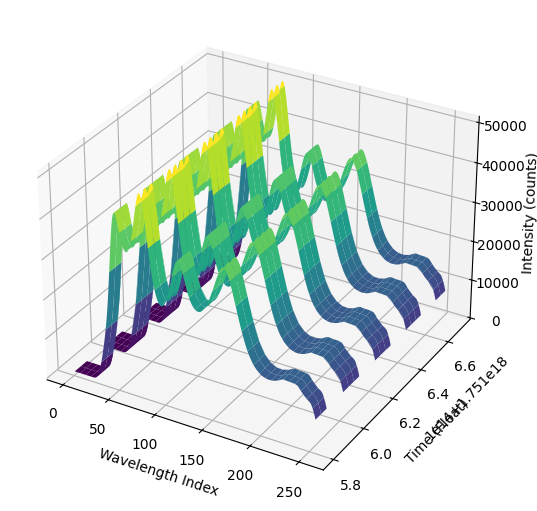

In [10]:
x, y = np.meshgrid(parked.wvl_idx, parked.time.astype(float))
z = parked.intensity

fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True, subplot_kw={'projection':'3d'})

surf = ax.plot_surface(x, y, z, cmap='viridis')

ax.set_xlabel('Wavelength Index')
ax.set_ylabel('Time (Float)')
ax.set_zlabel('Intensity (counts)')